# Предвзятость алгоритма ранжирования товаров Ozon - наивный подход

В наивном подходе предполагается, что лишь одна прокси-переменная определяет логику ранжирования товаров в поисковой выдаче. Это позволяет выявить предвзятость алгоритма в пользу определенных товаров на открытых данных. Анализ проведем на датафрейме данными о поисковой выдаче при введении неспецифических запросов, например "телевизор", на сайте Ozon. Помимо товаров сторонних продавцов, на платформе присутствуют и предложения владельца маркетплейса, в частности, собственные торговые марки Ozon - "Hartens", "Hola" и т.д.

### Загрузка необходимых библиотек и данных

In [43]:
import os
import pandas as pd
from matplotlib import figure
import pandas as pd
from scipy.stats import spearmanr, kendalltau, wilcoxon, mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


In [44]:
data = pd.read_csv("algo_data.csv")
data = data.drop_duplicates("url") # на всякий случай удалим дублирующиеся карточки товаров

In [45]:
data

,product_name,sellers,price,url,rating,num_ratings,black_friday,query,rank,Super-товар,Схема работы,Сумма заказов (₽),Доступность (%),Количество складов отгрузки (шт.),Доля рекламных расходов (%),Продажи 28 дней
0,"Xiaomi Телевизор 50"" 4K HDR, серый",Up Store Electronics,42565.0,https://www.ozon.ru/product/1108584701,4.8,1.0,0,телевизор,2,Да,FBO,7.705680e+05,1.000000,2,0.0227,43416.30
1,"Haier Телевизор Smart TV S1 50"" 4K UHD, черный",OZON Express,31989.0,https://www.ozon.ru/product/862512448,4.7,3.0,1,телевизор,3,Да,FBO,3.533890e+06,1.000000,5,0.0308,203450.04
2,"Hartens Телевизор HTY-32H06B-VZ 32"" HD, черный",OZON Express,8445.0,https://www.ozon.ru/product/856552942,4.7,12.0,1,телевизор,5,Да,FBO,6.043197e+07,1.000000,21,0.0000,1294787.40
3,"Hartens Телевизор HTY-43F06B-VZ 43"" Full HD, ч...",OZON Россия,12899.0,https://www.ozon.ru/product/856552956,4.7,10.0,1,телевизор,6,Да,FBO,1.559200e+05,0.964286,8,0.0000,1203863.67
4,"Hartens Телевизор HT-32H06B-VZ 32"" HD, черный",OZON Express,7590.0,https://www.ozon.ru/product/856553008,4.7,6.0,0,телевизор,7,Да,FBO,8.157228e+06,1.000000,14,0.0000,262234.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4322,"Apple Смартфон iPhone 11 4/128 ГБ, красный",Smartmarket,24677.0,https://www.ozon.ru/product/1387336388,4.7,146.0,1,смартфон,1038,Нет,FBS,3.257180e+05,1.000000,1,0.0000,45652.45
4323,Apple Смартфон iPhone 14 eSIM+SIM Ростест (EAC...,OZON Россия,70490.0,https://www.ozon.ru/product/705827794,4.9,275.0,1,смартфон,1039,Да,FBO,7.004930e+05,1.000000,1,0.0000,91637.00
4324,"Apple Смартфон iPhone XR. 3/128 ГБ, красный, В...",Expert mobile,18498.0,https://www.ozon.ru/product/1313042120,4.8,95.0,1,смартфон,1040,Нет,FBS,2.281160e+05,1.000000,1,0.0000,28301.94
4325,"Apple Смартфон iPhone 12 mini 4/128 ГБ, синий,...",Мобильный Мир,26458.0,https://www.ozon.ru/product/802049936,4.7,87.0,1,смартфон,1041,Нет,FBS,3.721160e+05,1.000000,1,0.0000,32014.18


### Подготовка данных
Часть информации для анализа берется из parsed_data - это те данные, которые были получены путем парсинга сайта Ozon. comparison_data - данные Ozon.Data, которые доступны [здесь](https://data.ozon.ru/). В качестве прокси-переменной берем продажи товара за последний месяц, которые отражают реальную популярность товара. Заметим, что таких данных изначально нет в датафрейме. Однако мы можем их получить, если умножим цену товара на конверсию с карточки товара в коризину на количество просмотров карточки товара за последний месяц. Здесь используется предположение, что конверсия из корзины к покупке товара примерно одинакова для всех товаров. Теперь нужно присвоить товарам дополнительные ранги по объему продаж за последние 28 дней.

In [46]:
data['Ранг по продажам 28 дней'] = data.groupby('query')['Продажи 28 дней'].rank(method='min', ascending=False)

### Группирование товаров

Теперь разделим товары на две группы - ozon_data и third_party. В ozon_data представлены все товары, которые продает Ozon (иногда для товаров разных продавцов генерируется одна карточка товаров, поэтому в этом датафрейме также есть товары, которые одновременно продают сторонние продавцы и Ozon). В third_party представлены товары, которые продают только сторонние продавцы, таких товаров значительно больше.

In [47]:
ozon_data = data[data['sellers'].str.contains('OZON', na=False)]
ozon_data = ozon_data[['url','sellers', 'Ранг по продажам 28 дней', "rank"]]
ozon_data = ozon_data.dropna()
ozon_data["rank"] = data.groupby('query').cumcount() # При удалении na ранги из изначального датасета смещаются, что приводит к искусственному занижению вообще всех товаров

ozon_data


,url,sellers,Ранг по продажам 28 дней,rank
1,https://www.ozon.ru/product/862512448,OZON Express,44.0,1
2,https://www.ozon.ru/product/856552942,OZON Express,2.0,2
3,https://www.ozon.ru/product/856552956,OZON Россия,3.0,3
4,https://www.ozon.ru/product/856553008,OZON Express,30.0,4
5,https://www.ozon.ru/product/856555293,OZON Express,16.0,5
...,...,...,...,...
4275,https://www.ozon.ru/product/1403103939,"OZON Казахстан, Infinix официальный магазин, Н...",452.0,557
4279,https://www.ozon.ru/product/870296680,"OZON Казахстан, Sale-Express, Mobilaboom",345.0,561
4285,https://www.ozon.ru/product/1326858322,"OZON Express, F5it, Абсолют Трейд",532.0,567
4315,https://www.ozon.ru/product/1334300541,"OZON Россия, TELE2, GS_Market",457.0,593


In [48]:
third_party = data[~data['sellers'].str.contains('OZON', na=False)]
third_party = third_party[['url','sellers', 'Ранг по продажам 28 дней',"rank"]]
third_party = third_party.dropna()

third_party

,url,sellers,Ранг по продажам 28 дней,rank
0,https://www.ozon.ru/product/1108584701,Up Store Electronics,221.0,2
6,https://www.ozon.ru/product/1403527428,Фирменный магазин Digma,171.0,9
9,https://www.ozon.ru/product/785766807,"Холодильник, Global Trading, ИМПЕРИЯ ТЕХНО",50.0,12
14,https://www.ozon.ru/product/1116246453,"ИМПЕРИЯ ТЕХНО, ИМПЕРИЯ-ТЕХНО, Up Store Electro...",62.0,15
17,https://www.ozon.ru/product/1108579416,"СМАРТ ЭЛЕКТРОНИКС, Up Store Electronics",69.0,18
...,...,...,...,...
4321,https://www.ozon.ru/product/1387449102,Smartmarket,396.0,1035
4322,https://www.ozon.ru/product/1387336388,Smartmarket,278.0,1038
4324,https://www.ozon.ru/product/1313042120,Expert mobile,352.0,1040
4325,https://www.ozon.ru/product/802049936,Мобильный Мир,329.0,1041


Очевидно, что для обеих групп реальные ранги в поисковой выдаче и ранги по объему продаж различаются, но проведем формальные тесты

In [56]:

spearman_corr_ozon, spearman_p_ozon = spearmanr(ozon_data['rank'], ozon_data['Ранг по продажам 28 дней'])
kendall_corr_ozon, kendall_p_ozon = kendalltau(ozon_data['rank'], ozon_data['Ранг по продажам 28 дней'])

spearman_corr_3p, spearman_p_3p = spearmanr(third_party['rank'], third_party['Ранг по продажам 28 дней'])
kendall_corr_3p, kendall_p_3p = kendalltau(third_party['rank'], third_party['Ранг по продажам 28 дней'])

print(f"Spearman correlation (Ozon): {spearman_corr_ozon}, p-value: {spearman_p_ozon}")
print(f"Kendall correlation (Ozon): {kendall_corr_ozon}, p-value: {kendall_p_ozon}")

print(f"Spearman correlation (3P): {spearman_corr_3p}, p-value: {spearman_p_3p}")
print(f"Kendall correlation (3P): {kendall_corr_3p}, p-value: {kendall_p_3p}")

Spearman correlation (Ozon): 0.5392610825688816, p-value: 6.799175804809725e-27
Kendall correlation (Ozon): 0.37577153715342726, p-value: 7.501446475682816e-25
Spearman correlation (3P): 0.34728746176209213, p-value: 2.4162707330350205e-91
Kendall correlation (3P): 0.23940514573323726, p-value: 1.8493463818854224e-91


Действительно, на любом разумном уровне значимости ранги различаются, но сам факт пока не позволяет утверждать ничего о предвзятости поискового алгоритма

### Графики

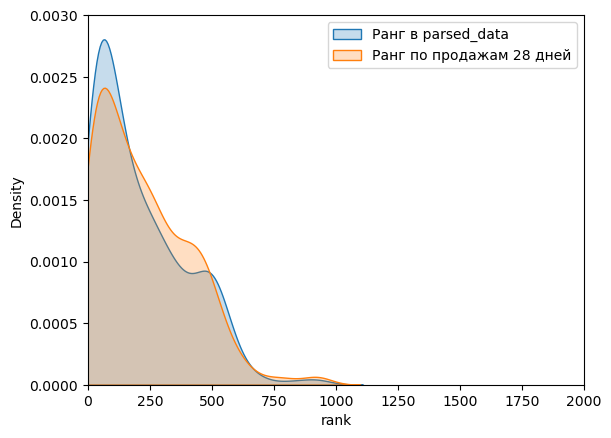

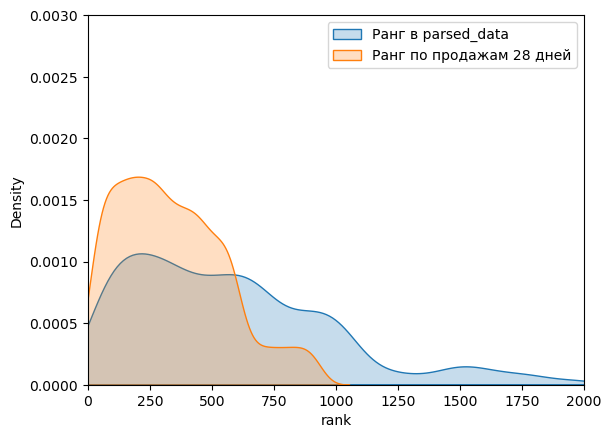

In [50]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
sns.kdeplot(ozon_data['rank'], fill=True, label='Ранг в parsed_data')
sns.kdeplot(ozon_data['Ранг по продажам 28 дней'], fill=True, label='Ранг по продажам 28 дней')

plt.legend()
plt.xlim(left=0,right=2000)
plt.ylim(top=0.003)
plt.show()


sns.kdeplot(third_party['rank'], fill=True, label='Ранг в parsed_data')
sns.kdeplot(third_party['Ранг по продажам 28 дней'], fill=True, label='Ранг по продажам 28 дней')

plt.legend()
plt.xlim(left=0,right=2000)
plt.ylim(top=0.003)
plt.show()

По графикам сложно определить, действительно ли существует занижение/завышение в поисковой выдаче, хотя в общем видно что товары Озон распределены ближе к началу страницы поисковой выдачи, чем должны бы были по данным о продажах товаров, а товары сторонних продавцов -  дальше. 

Используем другой подход - будем смотреть на плотности распределения разности реального ранга и ранга по прокси-переменной - объему продаж за 28 дней. Положительные значения говорят о том, что товар в реальной выдаче оказался ниже, чем должен был, если бы ранжирование было по прокси-переменной. Очевидно, что, при отсутствии предвзятости к товарам сторонних продавцов, распределения для двух групп не должны существенно различаться

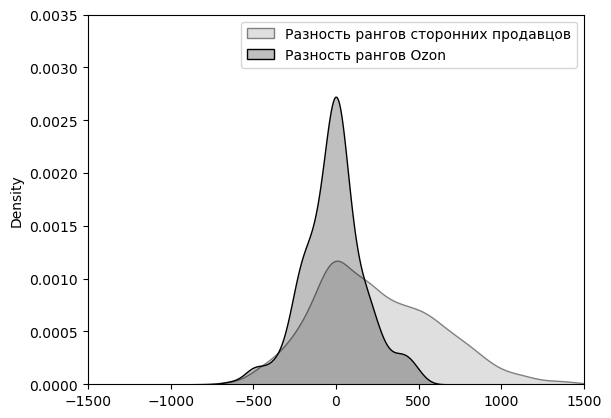

In [51]:
difference_3p = third_party['rank'] - third_party['Ранг по продажам 28 дней']
difference_ozon = ozon_data['rank'] - ozon_data['Ранг по продажам 28 дней']

sns.kdeplot(difference_3p, fill=True, label='Разность рангов сторонних продавцов', color=(0.5,0.5,0.5))
sns.kdeplot(difference_ozon, fill=True, label='Разность рангов Ozon', color=(0.0,0.0,0.0))

plt.legend()
plt.xlim(left=-1500, right=1500)
plt.ylim(top=0.0035)
plt.show()

Определим, отличаются ли от нуля средние значения распределений разности рангов. Нет четкой уверенности, что данные распределены нормально (по крайней мере, из графика это явно не следует), поэтому для начала проведем тест Шапиро-Уилка:

In [52]:
statistic_ozon, p_value_ozon = stats.shapiro(difference_ozon)
statistic_3p, p_value_3p = stats.shapiro(difference_3p)

print("Ozon - Статистика:", statistic_ozon,", P-значение:", p_value_ozon )
print("3P - Статистика:", statistic_3p, ", P-значение:", p_value_3p)

Ozon - Статистика: 0.9800034165382385 , P-значение: 0.00012051022349623963
3P - Статистика: 0.983372688293457 , P-значение: 6.154833286108401e-19


Данные не распределены нормально, поэтому для определения, отличаются ли от нуля средние значения распределений, используем критерий Уилкоксона:

In [53]:
stat_ozon, p_value_ozon = stats.wilcoxon(difference_ozon, alternative='two-sided')
stat_3p, p_value_3p = stats.wilcoxon(difference_3p, alternative='two-sided')
print("Ozon - Статистика Уилкоксона:", stat_ozon, ", p-значение:", p_value_ozon)
print("3P - Статистика Уилкоксона:", stat_3p, ", p-значение:", p_value_3p)

Ozon - Статистика Уилкоксона: 25174.5 , p-значение: 0.11311735785258256
3P - Статистика Уилкоксона: 982581.5 , p-значение: 5.4988223171046e-199


Для товаров, которые продает владелец маркетплейса, среднее разности реальных и смоделированных рангов не отличается от нуля, а для товаров сторонних продавцов на любом разумном уровне значимости среднее разности реальных рангов отлично от нуля, при этом в положительную сторону (то есть в сторону занижения товаров в поисковой выдаче - реальное место ниже смоделированного, выражение принимает знак +). Проведем тест Манна-Уитни, так как данные из обеих групп не распределены нормально:

In [54]:
stat, p_value = mannwhitneyu(difference_3p, difference_ozon, alternative='greater')
print(f"Тест Манна-Уитни: statistic={stat:.4f}, p-значение={p_value:.4f}")

Тест Манна-Уитни: statistic=765284.5000, p-значение=0.0000


На любом разумном уровне значимости средние для распределений разности рангов для товаров Ozon и товаров сторонних продавцов различаются, при этом среднее для товаров сторонних продавцов больше. Наивный подход не особо надежен, ведь он учитывает всего один параметр (что, с другой стороны, делает его простым и облегчает применение на открытых данных), что в общем снижает уверенность в результатах. Тем не менее, с его помощью мы установили, что, для выбранных неспецифических запросов, существует статистически значимое занижение товаров сторонних продавцов в поисковой выдаче на основании прокси-переменной, описывающей реальную популярность товаров

Подход с использованием методов машинного обучения см. [здесь](https://github.com/Seiron/coursework/blob/main/ml_analysis.ipynb)

Наконец рассчитаем средние отклонения от реальных рангов в поисковой выдаче. Вспомним, что положительные значения говорят о занижении результатов

In [55]:
print("Среднее отклонение от реальных рангов для товаров Ozon:", difference_ozon.mean())
print("Среднее отклонение от реальных рангов для товаров сторонних продавцов:", difference_3p.mean())

Среднее отклонение от реальных рангов для товаров Ozon: -14.136094674556213
Среднее отклонение от реальных рангов для товаров сторонних продавцов: 236.38449515473584


Занижение товаров сторонних продавцов оказалось значительным, в предположении, что популярность товара (которая выбрана как способ ранжирования по умолчанию) определяется исходя из объема продаж.